---
title: "QuantLib: Curva de Cupom Cambial"
description: |
    Como construir as curvas de cupom cambial, limpo e sujo, usando QuantLib com Python.
author:
  - name: Wilson Freitas
    url: {}
date: 2023-08-01
categories:
  - python
  - quantlib
  - brasa
  - B3
---

Vamos construir as curvas de cupom cambial, limpo e sujo, da B3 utilizando a biblioteca QuantLib.

Primeiramente vou fazer o *setup* do projeto `brasa` definindo o repositório que contém os dados.
Lembrando que o projeto `brasa` é um projeto em release *alpha* que venho trabalhando para organizar dados de fontes
públicas.

In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"
import brasa

Os demais pacotes importados são o *setup* básico que inclui: `pandas`, `numpy`, `datetime`, `matplotlib` e `pyarrow`.

In [2]:
from datetime import datetime

import QuantLib as ql
import pandas as pd
import numpy as np
import pyarrow.compute as pc
import matplotlib.ticker as mticker

Vou trabalhar com a data de referência 2023-07-14.
Para esta data vamos começar carregando os contratos futuros de dólar (DOL) e taxa DI (DI1) negociados na B3.
Utilizo o pacote `brasa` para obter os dados de preços de ajuste dos contratos futuros da B3.

In [3]:
refdate = datetime(2023, 7, 14)

fut_dol = (brasa
         .get_dataset("b3-futures-dol")
         .filter(pc.field("refdate") == refdate)
         .to_table()
         .to_pandas())

fut_di1 = (brasa
         .get_dataset("b3-futures-di1")
         .filter(pc.field("refdate") == refdate)
         .to_table()
         .to_pandas())

Agora vamos pegar a taxa DI para a data de referência utilizando o *dataset* de indicadores econômicos divulgado pela B3.
Isso é importante porque estes dados são utilizados pela B3 na construção das curvas.

In [4]:
cdi = (brasa
    .get_dataset("b3-economic-indicators-price")
    .filter(pc.field("refdate") == refdate)
    .filter(pc.field("commodity") == "DI1")
    .filter(pc.field("symbol") == "RTDI1")
    .to_table(columns=["price"])
    .to_pandas().iloc[0,0]) / 100

Preciso ainda obter as cotações de dólar, e acredite, temos diversas cotações de dólar.
As cotações de dólar são referentes à data de referência e ao dia anterior.
Para obter estes pontos de forma higiênica, vou fazer o *setup* da QuantLib e utilizar o calendário brasileiro para
filtrar os dados nas datas de interesse, a data de referência e o dia anterior.

In [5]:
today = ql.Date().from_date(refdate)
ql.Settings.instance().evaluationDate = today
calendar = ql.Brazil(ql.Brazil.Settlement)
calendar_act = ql.NullCalendar()

In [6]:
df_econ_ind = (brasa
    .get_dataset("b3-economic-indicators-price")
    .filter(pc.field("refdate") >= calendar.advance(today, ql.Period(-1, ql.Days)).to_date())
    .filter(pc.field("refdate") <= refdate)
    .filter(pc.field("commodity") == "DOL")
    .to_table()
    .to_pandas())
df_econ_ind

,refdate,commodity,symbol,description,price
0,2023-07-13,DOL,RTDOLCL,DÓLAR CUPOM LIMPO - CÁLCULADO PELA B3,4.7922
1,2023-07-13,DOL,RTDOLD1,DÓLAR B3 SPOT - 1 DIA,4.7949
2,2023-07-13,DOL,RTDOLD2,DÓLAR B3 SPOT - 2 DIAS,4.7967
3,2023-07-13,DOL,RTDOLT1,PTAX800 VENDA,4.8038
4,2023-07-14,DOL,RTDOLCL,DÓLAR CUPOM LIMPO - CÁLCULADO PELA B3,4.7896
5,2023-07-14,DOL,RTDOLD1,DÓLAR B3 SPOT - 1 DIA,4.7901
6,2023-07-14,DOL,RTDOLD2,DÓLAR B3 SPOT - 2 DIAS,4.7905
7,2023-07-14,DOL,RTDOLT1,PTAX800 VENDA,4.7957


Como podemos observar, para cada data de referência temos 4 cotações de dólar:

- Dólar cupom limpo cálculado pela B3 a partir do casado
- Dólar spot para liquidação em D+1
- Dólar spot para liquidação em D+2
- PTAX800 cotação de venda

Precisamos pegar a cotação da PTAX800 (apenas PTAX) do dia anterior para calcular o cupom sujo.
O `symbol` da PTAX, de acordo com a tabela anterior, é `RTDOLT1`.
Assim vamos filtrar por este símbolo na data do dia anterior.
Para calcular o cupom limpo utilizamos o dólar cupom limpo, filtrando pelo símbolo `RTDOLCL`.

Antes de filtrar vou criar uma função para converter `ql.Date` para `datetime.datetime`.
Com o pandas é mais fácil trabalhar com `datetime`.

In [7]:
def ql_to_datetime(d):
    # reference: https://stackoverflow.com/questions/45087828/python-quantlib-convert-quantlib-date-to-datetime
    # datetime.datetime has methods fromordinal() and toordinal() to convert between datetime.datetime and an integer
    # that represents the date.
    # ql.Date also has the method serialNumber() to convert ql.Date to integer and its constructor accepts the integer
    # as well.
    # datetime.datetime uses 0001-01-01 as 1 with increments in days 
    # ql.Date uses 1899-12-31 as 0
    return datetime.fromordinal(d.serialNumber() + datetime(1899, 12, 31).toordinal() - 1)

Para seguir com o cálculo do cupom cambial vamos juntar os dados de futuros de taxa DI com os futuros de dólar.

In [8]:
fut = fut_dol.merge(fut_di1, on=["refdate", "maturity_date", "business_days"], suffixes=("_dol", "_di1"))

Agora sim, procedemos com o cálculo do cupom sujo.
A curva de cupom cambial tem os vértices nas datas de *fixing*, que são as data onde a cotação do dólar é fixada para
a liquidação do contrato.
Essa abordagem é diferente do que é implementado pela B3, que utiliza as data de vencimento como vértices da curva.
O cálculo do cupom cambial sujo é dado pela fórmula.

$$
\left( 1 + c_{v}(t) \cdot \frac{DC_{v}(t)}{360} \right) = \frac{ \frac{100000}{PUDI1_{v}(t)} }{ \frac{PUDOL_{v}(t)}{PTAX_{t-1} \cdot 1000} }
$$

$DC_{v}(t)$ são os dias corridos da data de referência até a data de *fixing*.

In [9]:
yesterday = calendar.advance(today, -1, ql.Days)
ptax_1 = df_econ_ind.loc[(df_econ_ind["refdate"] == ql_to_datetime(yesterday)) & (df_econ_ind["symbol"] == "RTDOLT1"), "price"].item()
di1_factor = 100000 / fut["settlement_price_di1"]
dol_factor = fut["settlement_price_dol"] / (ptax_1 * 1000)
fixing = [calendar.advance(d, 1, ql.Days)
          for d in [calendar.adjust(ql.Date.from_date(d), ql.Following)
                    for d in fut["maturity_date"]]]
dc = [calendar_act.businessDaysBetween(today, d) for d in fixing]
fut["fixing"] = [ql_to_datetime(d) for d in fixing]
fut["cupom_sujo"] = (di1_factor / dol_factor - 1) * 360 / dc

O cálculo do cupom cambial limpo é dado pela fórmula.

$$
\left( 1 + c_{v}(t) \cdot \frac{DC_{v}^{CL}(t)}{360} \right) = \frac{ \frac{100000}{PUDI1_{v}(t)}\frac{1}{(1 + CDI_t)^{1/252}} }{ \frac{PUDOL_{v}(t)}{DOLCL_{t-1} \cdot 1000} }
$$

$DC_{v}^{CL}(t)$ são os dias corridos da data de referência, mais 2 dias úteis, até a data de *fixing*.
A motivação para essa mudança é que o dólar cupom limpo é liquidado em 2 dias úteis, portanto, a curva deve começar
nesta data.
Por este motivo, também é necessário retirar 1 dia de CDI do fator da taxa DI.

In [10]:
spot = df_econ_ind.loc[(df_econ_ind["refdate"] == refdate) & (df_econ_ind["symbol"] == "RTDOLCL"), "price"].item()
di1_factor = (100000 / fut["settlement_price_di1"]) / ((1 + cdi) ** (1/252))
dol_factor = fut["settlement_price_dol"] / (spot * 1000)
dc = [calendar_act.businessDaysBetween(calendar.advance(today, 2, ql.Days), ql.Date.from_date(d)) for d in fut["fixing"]]
fut["cupom_limpo"] = (di1_factor / dol_factor - 1) * 360 / dc
fut["dc_limpo"] = dc

Para termos de comparação do *shape* da estrutura a termos vamos fazer um gráfico com a curva americana de *Treasuries*.

In [11]:
us_curve = pd.DataFrame({
    "dc": pd.Series([1, 2, 3, 4, 6, 12, 24, 36, 60, 72, 120, 240, 360]) * 30,
    "rate": pd.Series([5.37, 5.49, 5.49, 5.53, 5.52, 5.34, 4.74, 4.35, 4.04, 3.94, 3.83, 4.11, 3.93]) / 100,
})
us_curve["date"] = [ql_to_datetime(calendar_act.advance(today, d, ql.Days)) for d in us_curve["dc"]]

<Axes: xlabel='date'>

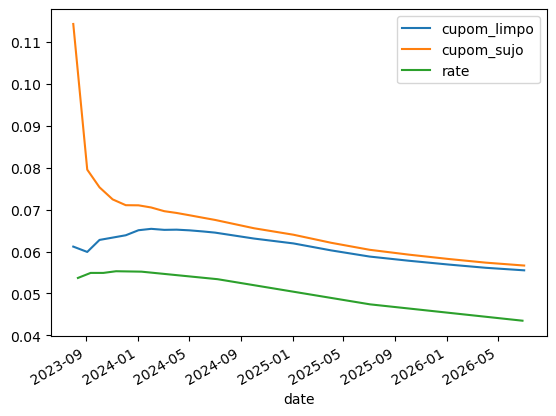

In [12]:
ax = fut[["fixing", "cupom_limpo", "cupom_sujo"]].set_index("fixing").plot()
us_curve[["date", "rate"]].query("date <= '2027-01-01'").set_index("date").plot(ax=ax)